In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%capture
%%R
if (!require("ggplot2"))    install.packages('ggplot2')
if (!require("forecast"))   install.packages('forecast')
if (!require("tidyverse"))  install.packages('tidyverse')
if (!require("KFAS"))       install.packages('KFAS')
if (!require("TSA")) install.packages('TSA')
if (!require("xts"))        install.packages('xts')
if (!require("urca"))  install.packages('urca')
if (!require("sqldf"))  install.packages('sqldf')
if (!require("ggpubr"))  install.packages('ggpubr')
if (!require("DMwR"))   remotes::install_version("DMwR", version="0.4.1")
## La libreria DMwR è stata deprecata recentemente, l'unico utilizzo di tale package è la sola funzione "unscale"
## Durante la stesura di questo foglio ipnby a volte ho dovuto eseguire questa cella diverse volte poichè non installava tutte le librerie al primo colpo

Dopo una rapida ricerca di valori nulli e/o mancanti (risultata negativa), si è passato al controllo dei valori orario nell'arco dei 730 giorni presenti nel dataset. Tale ricerca ha portato all'evidenza di due valori mancanti dell'Ora 3, tale mancanza è da attribuire al cambio dell'ora legale. 
Il passo successivo è stato quello di aggiungere manualmente l'ora mancante con il valore precedente.

In [ ]:
%%capture
%%R
data <- read.csv("/content/drive/MyDrive/TrainingSet.csv",sep=";")
#sum(is.na(data))
data %>% group_by(Ora)%>% count(Ora)
Representation <- aggregate(Ora ~ DATA, data=data,FUN=function(x){length(unique(x))})
legal_hours <- sqldf('SELECT DATA
              FROM Representation
              WHERE Ora !=24')

legal_hours <- sqldf( "SELECT DATA, Ora, VALORE 
              FROM data 
              WHERE DATA == '2019-03-31' OR DATA == '2020-03-29'")

legal_hours_2019 <- sqldf ("SELECT VALORE
                  FROM data
                  WHERE DATA =='2019-03-31'AND Ora==2 ")
legal_hours_2020 <- sqldf ("SELECT VALORE
                  FROM data
                  WHERE DATA =='2020-03-29'AND Ora==2 ")

new_values <- data.frame('2019-03-31', 3, 3039997)      
names(new_values) <- c("DATA", "Ora", "VALORE") 
data <- rbind(data[1:5066,],new_values,data[-(1:5066),])

new_values <- data.frame('2020-03-29', 3, 2329514)      
names(new_values) <- c("DATA", "Ora", "VALORE") 
data <- rbind(data[1:13802,],new_values,data[-(1:13802),])
rownames(data) <- 1:nrow(data)



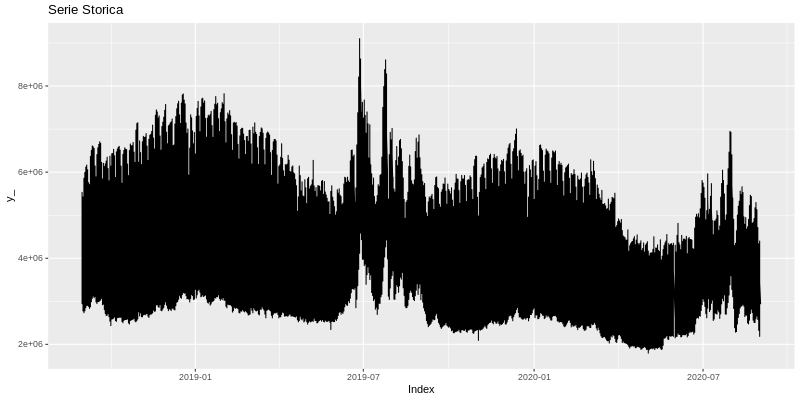

In [ ]:
%%R -w 800 -h 400
data <- data %>%
  dplyr::mutate(data = paste(DATA, Ora, sep = ":"),
                data = lubridate::parse_date_time(data, 'Y:m-:d:H'),
                data = format(strptime(data, "%Y-%m-%d %H:%M"),'%Y-%m-%d %H:%M'))
y_ <- xts(data$VALORE, as.Date(as.character(data$data), format = "%Y-%m-%d %H:%M"))
autoplot(y_, main="Serie Storica")

Per poter verificare la presenza o meno di stagionalità nella Time Series si è deciso di costruire diverse serie temporali con frequenze differenti (giornaliera, settimanale, mensile ed infine annuale)
Gli ultimi due oggetti sono stati aggregati in termini medi i valori.
Dai grafici è possibile osservare una stagionalità giornaliera, in quanto i valori aumentano nelle ore del giorno lavorativo e diminuiscono nella pausa pranzo, a fine orario lavorativo e di notte.
Il settimanale conferma quanto detto precedentemente; inoltre, si osserva un leggero trend crescente da inizio a fine settimana. Non è presente stagionalità mensile, in quanto non esiste un pattern uguale per tutti i mesi. Infine, è possibile notare una ciclo annuale.

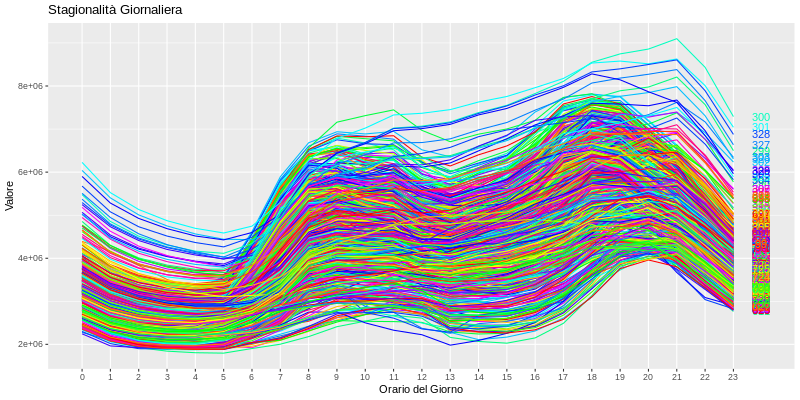

In [ ]:
%%R -w 800 -h 400
y_daily <- y_ %>% ts(frequency=24)
y_weekly <- y_ %>% ts(frequency = 168)
ag_mean_values <- aggregate(VALORE ~ DATA, data, mean)

ggseasonplot(y_daily,year.labels = TRUE,                        
           year.labels.left = FALSE,
           main = "Stagionalità Giornaliera",
           ylab = "Valore",            
           xlab = "Orario del Giorno"
           , col=rainbow(24))

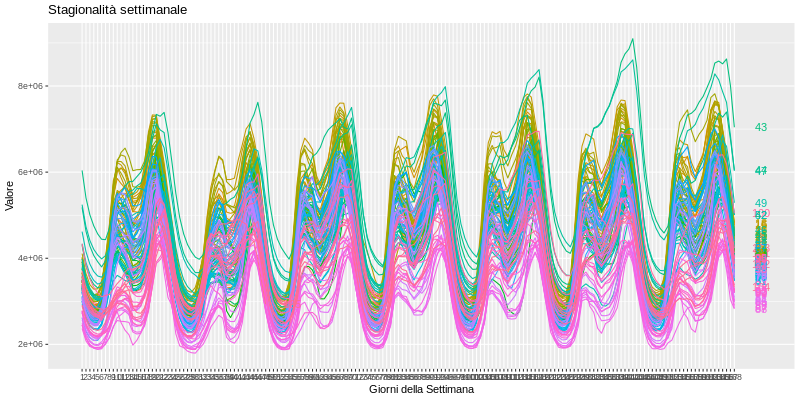

In [ ]:
%%R -w 800 -h 400
ggseasonplot(y_weekly,                      
             year.labels = TRUE,                        
             year.labels.left = FALSE, 
             main = "Stagionalità settimanale",
             ylab = "Valore",              
             xlab = "Giorni della Settimana")

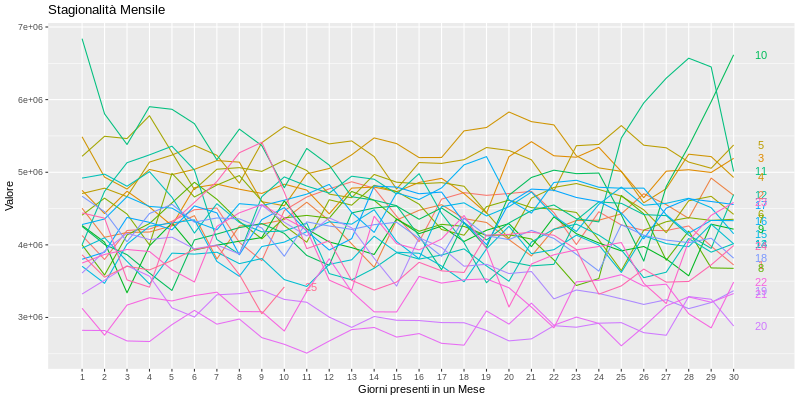

In [ ]:
%%R -w 800 -h 400
ag <- aggregate(VALORE ~ DATA, data, mean)
ggseasonplot(ts(ag[,"VALORE"], frequency=30),                     
             year.labels = TRUE,                        
             year.labels.left = FALSE, 
             main = "Stagionalità Mensile",
             ylab = "Valore",              
             xlab = "Giorni presenti in un Mese")

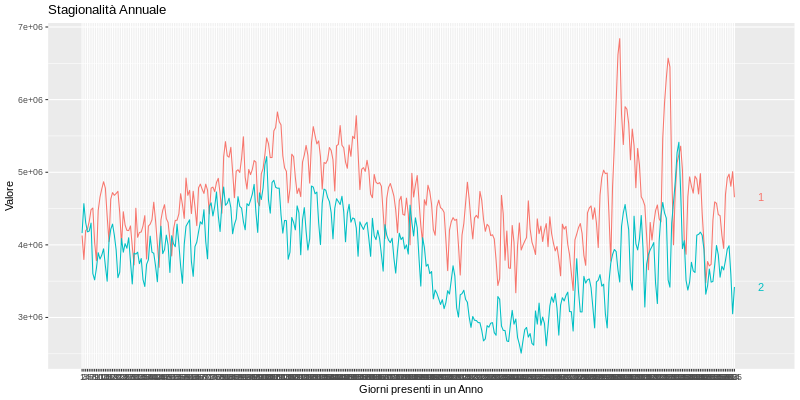

In [ ]:
%%R -w 800 -h 400
ggseasonplot(ts(ag[,"VALORE"], frequency=730/2),                      
             year.labels = TRUE,                        
             year.labels.left = FALSE,                
             main = "Stagionalità Annuale",              
             ylab = "Valore",            
             xlab = "Giorni presenti in un Anno")

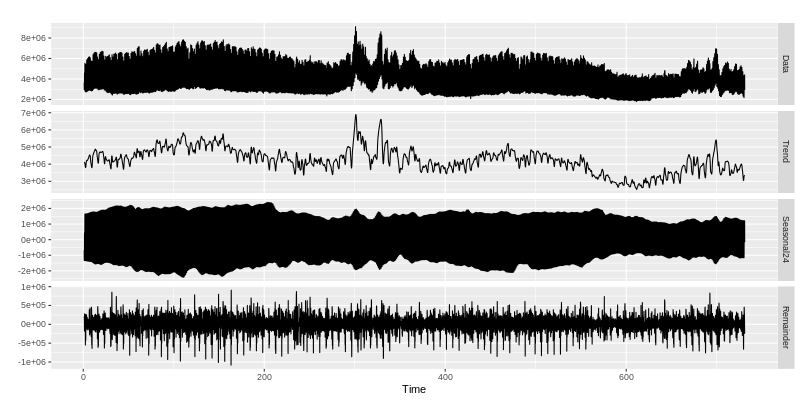

In [ ]:
%%R -w 800 -h 400
autoplot(mstl(ts(data$VALORE, frequency = 24)))

# **ARIMA**

Osservando i correlogrammi ACF/PACF è evidente la stagionalità giornaliera della serie.
Inoltre nel grafico PACF si può individuare un AR(3) non stagionale.

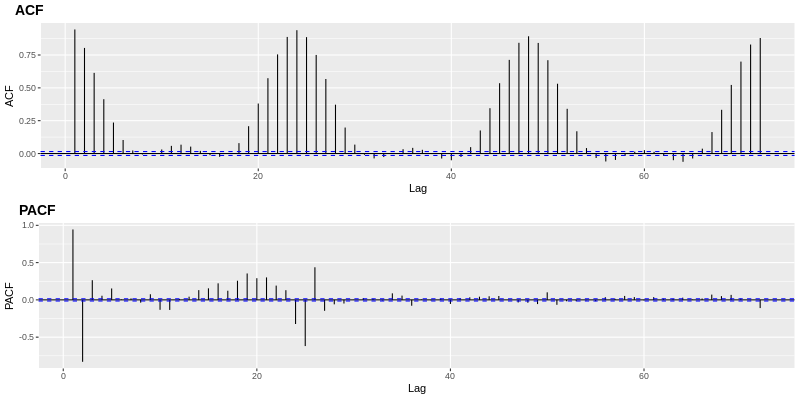

In [ ]:
%%R -w 800 -h 400
y <- as.vector(y_daily)

ggarrange(ggAcf(y,
                lag.max = 72,        
                main = ""),
          ggPacf(y,
                 lag.max = 72,       
                 main = ""),
          labels = c("ACF", "PACF"),
          nrow = 2, ncol= 1)

Mediante l'utilizzo del comando diff() si elimina la stagionalità giornaliera.

In [ ]:
%%R
dy <- diff(y_daily,
           lag = 24)    %>%
  diff(differences = 1) %>%
  diff(differences = 1)

Successivamente viene eseguito lo split del dataset andando a formare un training set e un validation set (90%/10%).

In [ ]:
%%R 
tt <- ts(scale(data$VALORE),start=1,frequency=24)
y_train <- ts(tt[1:15768,],frequency=24, start=1) #90%
y_test <- ts(tt[15769:17518],frequency=24, start=658) #10%
n_test = length(y_test)

R[write to console]: `geom_smooth()` using formula 'y ~ x'



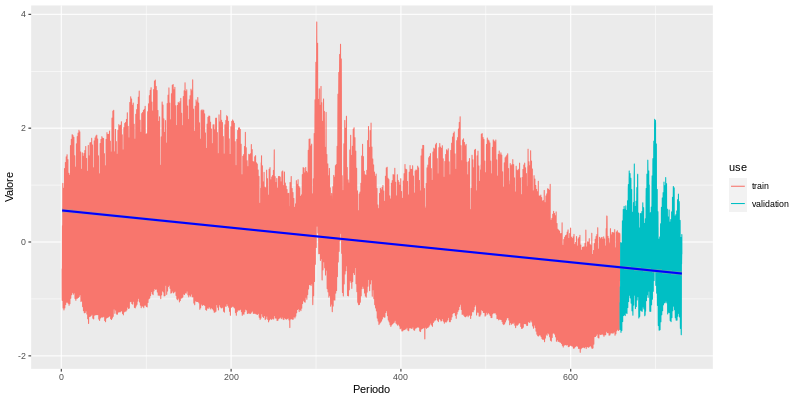

In [ ]:
%%R -w 800 -h 400
rbind(data.frame(Periodo=index(y_train), Valore=coredata(y_train), use="train"),
      data.frame(Periodo=index(y_test), Valore=coredata(y_test), use="validation")) %>%
  ggplot(aes(x=Periodo, y=Valore)) +
  geom_line(aes(colour = use)) +
  stat_smooth(method = "lm", se = T, col="blue", level=0.99)

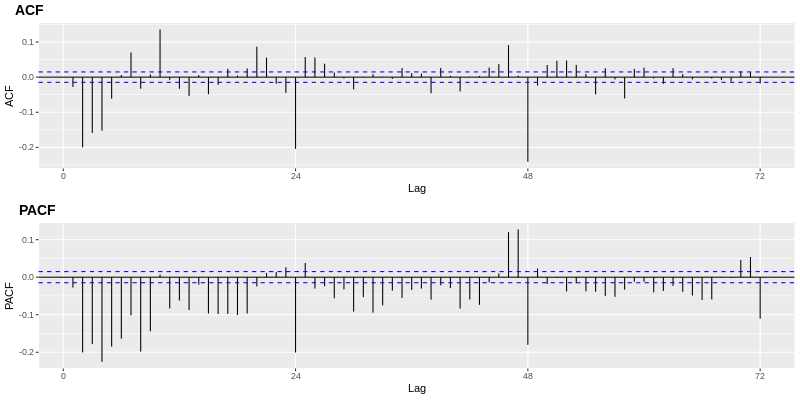

In [ ]:
%%R -w 800 -h 400
ggarrange(ggAcf(dy,
                lag.max = 72,        
                main = ""),
          ggPacf(dy,
                 lag.max = 72,       
                 main = ""),
          labels = c("ACF", "PACF"),
          nrow = 2, ncol= 1)

In [ ]:
%%R -w 800 -h 400
##ARIMA 1
arima1 <- Arima(y_train,c(3,0,0), list(order=c(0,1,0),
                                     lambda="auto"), 
              include.constant = TRUE )      

summary(arima1)

Series: y_train 
ARIMA(3,0,0)(0,1,0)[24] with drift 

Coefficients:
         ar1      ar2     ar3  drift
      1.6129  -0.8808  0.1984  0e+00
s.e.  0.0078   0.0133  0.0078  4e-04

sigma^2 estimated as 0.007807:  log likelihood=15861.52
AIC=-31713.03   AICc=-31713.03   BIC=-31674.71

Training set error measures:
                      ME       RMSE       MAE     MPE     MAPE      MASE
Training set 4.35315e-06 0.08827788 0.0536021 11.7539 43.15574 0.2446096
                    ACF1
Training set -0.01122477


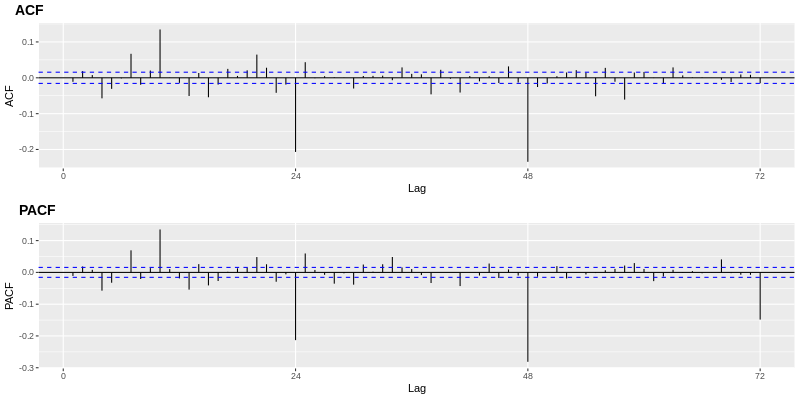

In [ ]:
%%R -w 800 -h 400
ggarrange(ggAcf(arima1$residuals,
                lag.max = 72,        
                main = ""),
          ggPacf(arima1$residuals,
                 lag.max = 72,       
                 main = ""),
          labels = c("ACF", "PACF"),
          nrow = 2, ncol= 1)

Osservando il correlogramma ACF si può denotare una MA(2) stagionale.


	Ljung-Box test

data:  Residuals from ARIMA(3,0,0)(0,1,0)[24] with drift
Q* = 2374.8, df = 44, p-value < 2.2e-16

Model df: 4.   Total lags used: 48



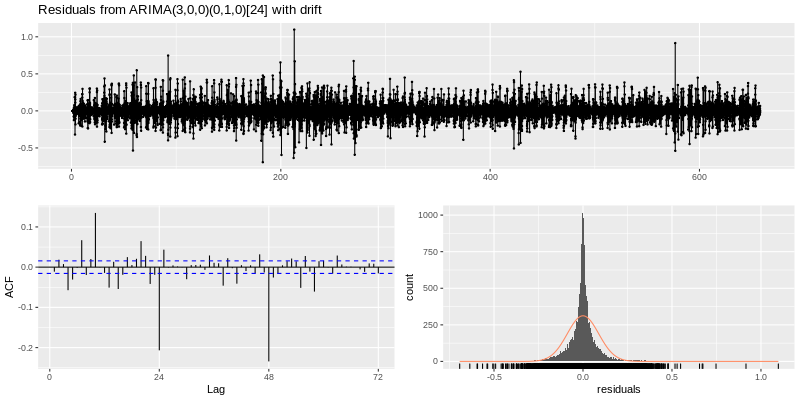

In [ ]:
%%R -w 800 -h 400

checkresiduals(arima1)

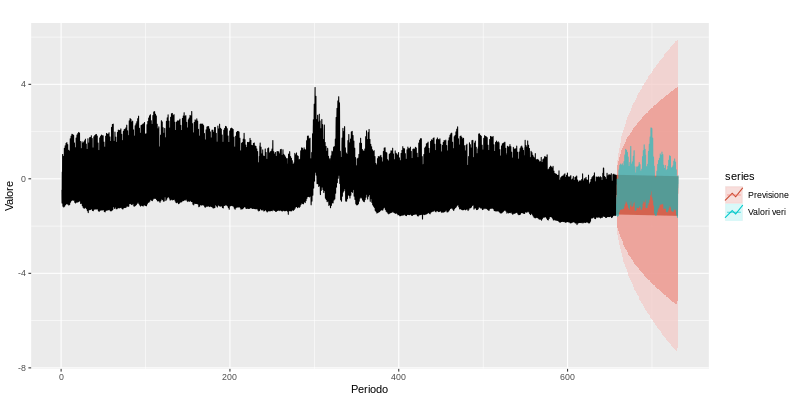

In [ ]:
%%R -w 800 -h 400
pred1 <- forecast(arima1, h=n_test)

pred_arima1 <- ts(pred1$mean, start=658, frequency = 24)

autoplot(y_train) +
  autolayer(pred1,series="Previsione", alpha=0.7) +
  autolayer(y_test, series="Valori veri", alpha=0.6) +
  xlab("Periodo") +
  ylab("Valore")

In [ ]:
%%R
mae_arima1 <- mean(abs(pred_arima1-y_test))
mae_arima1

[1] 0.4628953


In [ ]:
%%R
##ARIMA 2
arima2 <- Arima(y_train,c(3,0,0), list(order=c(0,1,2),
                                     lambda="auto"), 
              include.constant = TRUE )      

summary(arima2)

Series: y_train 
ARIMA(3,0,0)(0,1,2)[24] with drift 

Coefficients:
         ar1      ar2     ar3     sma1     sma2  drift
      1.5912  -0.8357  0.1833  -0.4480  -0.3317  0e+00
s.e.  0.0079   0.0134  0.0078   0.0075   0.0073  1e-04

sigma^2 estimated as 0.005925:  log likelihood=18023.27
AIC=-36032.54   AICc=-36032.53   BIC=-35978.89

Training set error measures:
                        ME       RMSE        MAE     MPE     MAPE      MASE
Training set -1.778934e-05 0.07690342 0.05026339 5.82452 36.25787 0.2293736
                     ACF1
Training set -0.009533076


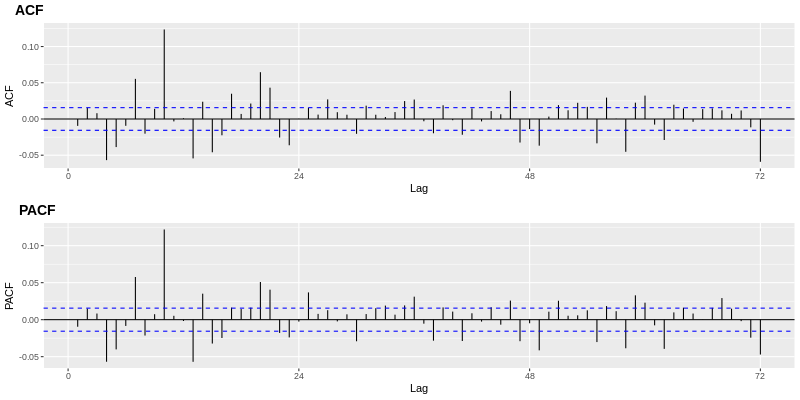

In [ ]:
%%R -w 800 -h 400
ggarrange(ggAcf(arima2$residuals,
                lag.max = 72,        
                main = ""),
          ggPacf(arima2$residuals,
                 lag.max = 72,       
                 main = ""),
          labels = c("ACF", "PACF"),
          nrow = 2, ncol= 1)


	Ljung-Box test

data:  Residuals from ARIMA(3,0,0)(0,1,2)[24] with drift
Q* = 753.84, df = 42, p-value < 2.2e-16

Model df: 6.   Total lags used: 48



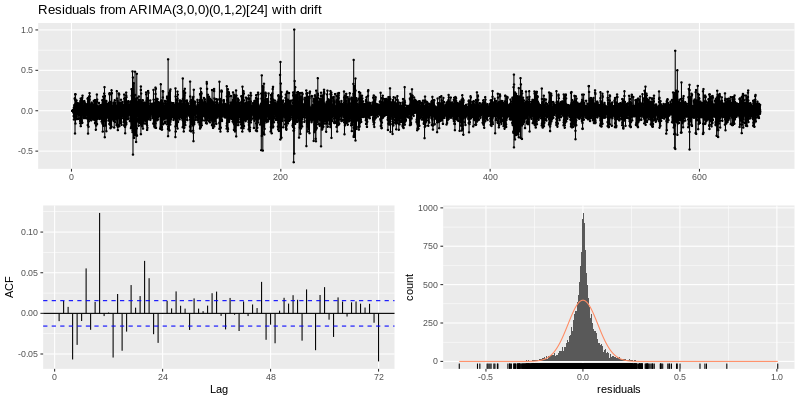

In [ ]:
%%R -w 800 -h 400

checkresiduals(arima2)

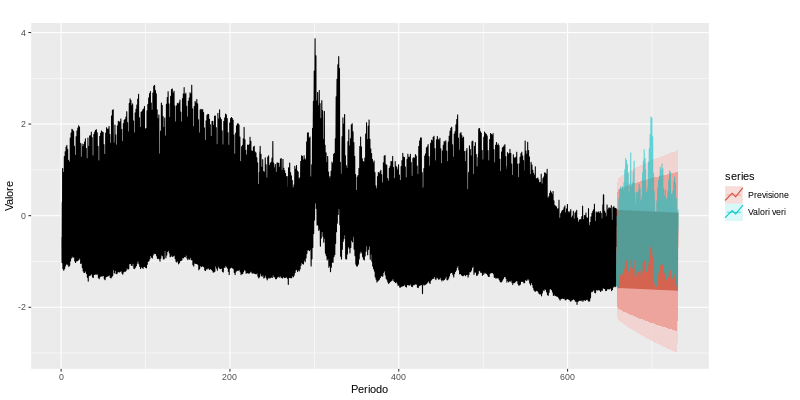

In [ ]:
%%R -w 800 -h 400

pred2 <- forecast(arima2, h=n_test)

pred_arima2 <- ts(pred2$mean, start=658, frequency = 24)

autoplot(y_train) +
  autolayer(pred2,series="Previsione", alpha=0.7) +
  autolayer(y_test, series="Valori veri", alpha=0.6) +
  xlab("Periodo") +
  ylab("Valore")

In [ ]:
%%R
mae_arima2 <- mean(abs(pred_arima2-y_test))
mae_arima2

[1] 0.5128199


Mediante il comando auto.arima, si esegue un grid search per trovare i parametri migliori.

In [ ]:
%%R

AutoArima = auto.arima(y_train,seasonal=TRUE)
AutoArima

Series: y_train 
ARIMA(5,0,0)(2,1,0)[24] 

Coefficients:
         ar1      ar2     ar3     ar4     ar5     sar1     sar2
      1.5912  -0.8335  0.1805  -0.070  0.0735  -0.2667  -0.2907
s.e.  0.0079   0.0150  0.0164   0.015  0.0079   0.0077   0.0076

sigma^2 estimated as 0.00679:  log likelihood=16958.78
AIC=-33901.56   AICc=-33901.55   BIC=-33840.25


In [ ]:
%%R

##ARIMA 3
arima3 <- Arima(y_train,c(5,0,0), list(order=c(2,1,0),
                                     lambda="auto"), 
              include.constant = TRUE )      

summary(arima3)

Series: y_train 
ARIMA(5,0,0)(2,1,0)[24] with drift 

Coefficients:
         ar1      ar2     ar3     ar4     ar5     sar1     sar2  drift
      1.5912  -0.8335  0.1806  -0.070  0.0735  -0.2668  -0.2907  0e+00
s.e.  0.0080   0.0150  0.0164   0.015  0.0079   0.0077   0.0076  3e-04

sigma^2 estimated as 0.006791:  log likelihood=16958.79
AIC=-33899.57   AICc=-33899.56   BIC=-33830.6

Training set error measures:
                       ME      RMSE        MAE      MPE     MAPE     MASE
Training set 7.125311e-06 0.0823211 0.05290032 3.957259 39.71612 0.241407
                     ACF1
Training set -0.000783476


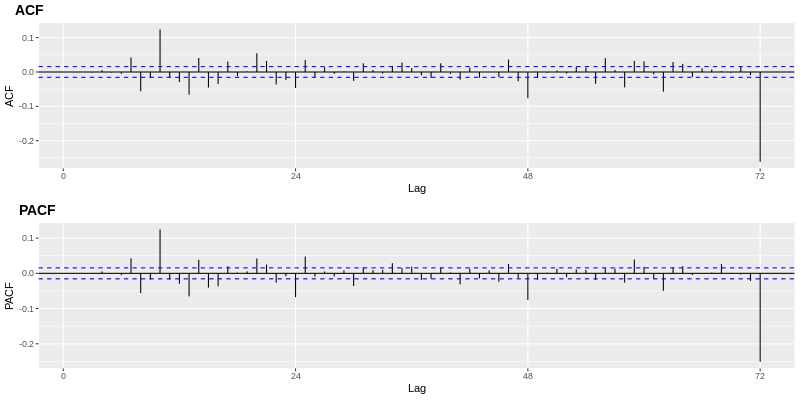

In [ ]:
%%R -w 800 -h 400
ggarrange(ggAcf(arima3$residuals,
                lag.max = 72,        
                main = ""),
          ggPacf(arima3$residuals,
                 lag.max = 72,       
                 main = ""),
          labels = c("ACF", "PACF"),
          nrow = 2, ncol= 1)


	Ljung-Box test

data:  Residuals from ARIMA(5,0,0)(2,1,0)[24] with drift
Q* = 858, df = 40, p-value < 2.2e-16

Model df: 8.   Total lags used: 48



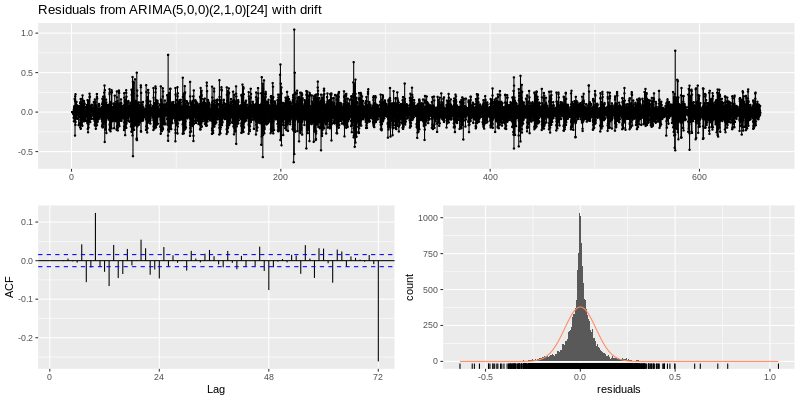

In [ ]:
%%R -w 800 -h 400

checkresiduals(arima3)

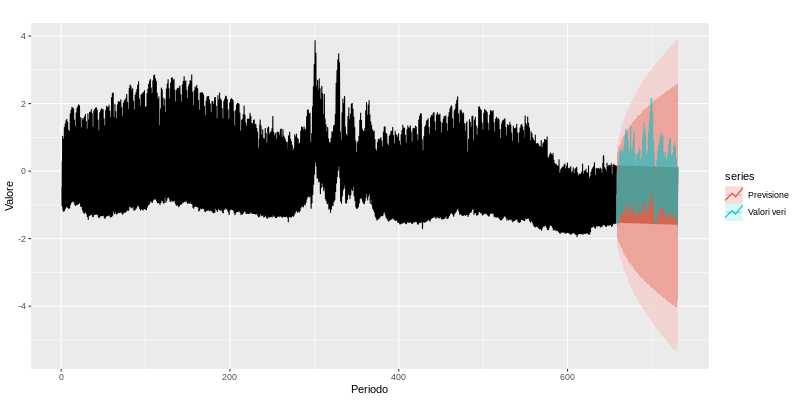

In [ ]:
%%R -w 800 -h 400

pred3 <- forecast(arima3, h=n_test)

pred_arima3 <- ts(pred3$mean, start=658, frequency = 24)

autoplot(y_train) +
  autolayer(pred3,series="Previsione", alpha=0.7) +
  autolayer(y_test, series="Valori veri", alpha=0.6) +
  xlab("Periodo") +
  ylab("Valore")

In [ ]:
%%R

mae_arima3 <- mean(abs(pred_arima3-y_test))
mae_arima3

[1] 0.4643997


 # **UCM**

In [ ]:
%%capture
%%R

## LLT con stagionalità dummy
var_train <- var(y_train)


ucm_mod1 <- SSModel(y_train ~ SSMtrend(2, list(NA,0)) +
                      SSMseasonal(24, NA, "dummy"),
                      H = NA)

ucm_mod1$P1inf[] <- 0
ucm_mod1$a1[1] <- mean(y_train, na.rm = TRUE)
diag(ucm_mod1$P1) <- var_train


ucm_fit1<- fitSSM(ucm_mod1, inits = log(c(var_train/10,
                                          var_train/200,      
                                          var_train/2,       
                                          var_train/20)))     

ucm_fit1$optim.out$convergence                                 
ucm_fit1$model$Q  

ucm_pred1 <- predict(ucm_fit1$model,
                     n.ahead = n_test) 
ucm_pred_1 <- ts(ucm_pred1,                             
                start = 658,                           
                frequency = 24)

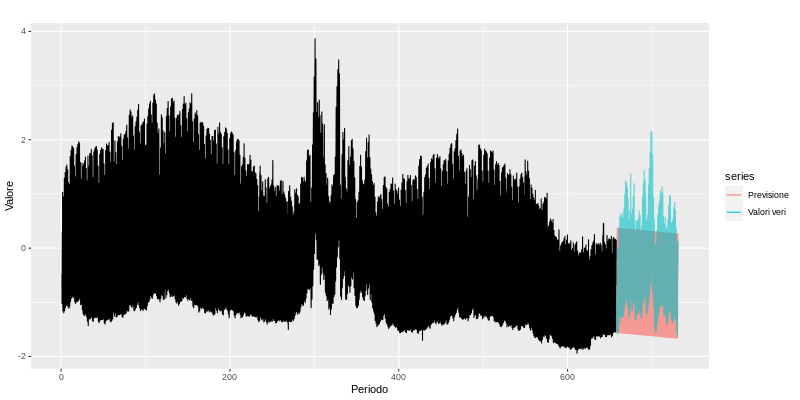

In [ ]:
%%R -w 800 -h 400

autoplot(y_train) +
  autolayer(ucm_pred1,series="Previsione", alpha=0.7) +
  autolayer(y_test, series="Valori veri", alpha=0.6) +
  xlab("Periodo") +
  ylab("Valore")

In [ ]:
# il calcolo del mae per i modelli UCM relativo al training set funzionava a singhiozzo su colab, pertanto sono state messe sotto commento
# onde evitare problemi nel possibile futuro run del codice
#%%R
#ucm_mae_train1 <-mean(abs(unscale(fitted(ucm_fit1$model), tt) - unscale(y_train, tt)))
#ucm_mae_train1

[1] 0.009936561


In [ ]:
%%R
ucm_mae1 <- mean(abs(y_test - ucm_pred1))
ucm_mae1

[1] 0.4628982


In [ ]:
%%capture
%%R

ucm_mod2 <- SSModel(y_train ~ SSMtrend(2, list(NA,0)) +
                      SSMseasonal(24, NA, "trigonometric"),
                    H = NA)

updt_mod2 <- function(pars, model) {
  model$Q[1, 1, 1] <- exp(pars[1])
  model$Q[2, 2, 1] <- exp(pars[2])
  model$Q[3, 3, 1] <- exp(pars[3])
  model$Q[4, 4, 1] <- exp(pars[4])
  diag(model$Q[5 : 25, 5 : 25, 1]) <- exp(pars[5])
  model$H[1, 1, 1] <- exp(pars[6])
  model
}

ucm_fit2 <- fitSSM(ucm_mod2,
               log(c(var_train/20, 
                     var_train/100, 
                     var_train/100, 
                     var_train/100, 
                     var_train/10,  
                     var_train/10)), 
               updt_mod2
)

ucm_fit2$optim.out$convergence                                
ucm_fit2$model$Q
ucm_pred2 <- predict(ucm_fit2$model,
                     n.ahead = n_test) 
ucm_pred_2 <- ts(ucm_pred2,                             
                start = 658,                          
                frequency = 24)

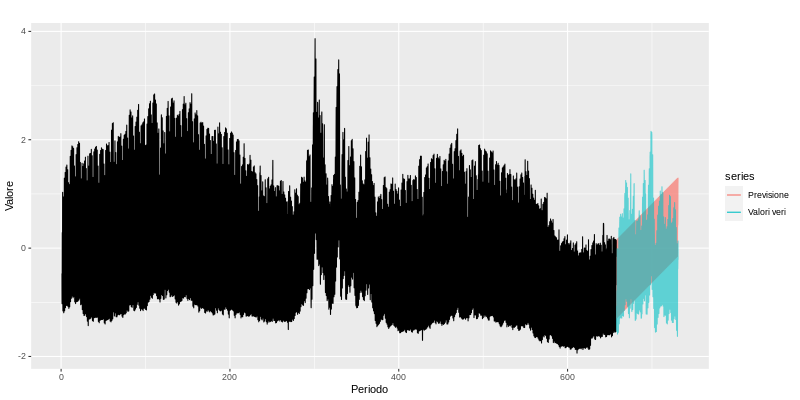

In [ ]:
%%R -w 800 -h 400

autoplot(y_train) +
  autolayer(ucm_pred2,series="Previsione", alpha=0.7) +
  autolayer(y_test, series="Valori veri", alpha=0.6) +
  xlab("Periodo") +
  ylab("Valore")

In [ ]:
#%%R
#ucm_mae_train2 <-mean(abs(unscale(fitted(ucm_fit2$model), tt) - unscale(y_train, tt)))
#ucm_mae_train2

[1] 0.05317889


In [ ]:
%%R
ucm_mae2 <- mean(abs(y_test - ucm_pred_2))
ucm_mae2

[1] 0.5335358


In [ ]:
%%capture
%%R

ucm_mod3 <- SSModel(y_train ~ SSMtrend(1, list(NA,0)) +
                      SSMseasonal(24, NA, "dummy")+
                      SSMcycle(365*24),
                    H = NA)



ucm_fit3 <- fitSSM(ucm_mod3,
                   log(c(var_train/20, 
                         var_train/100, 
                         var_train/100, 
                         var_train/100, 
                         var_train/10,  
                         var_train/10)),
)

ucm_fit3$optim.out$convergence                                 
ucm_fit3$model$Q

ucm_pred3 <- predict(ucm_fit3$model,
                     n.ahead = n_test) 
ucm_pred_3 <- ts(ucm_pred3,                           
                start = 658,                          
                frequency = 24)

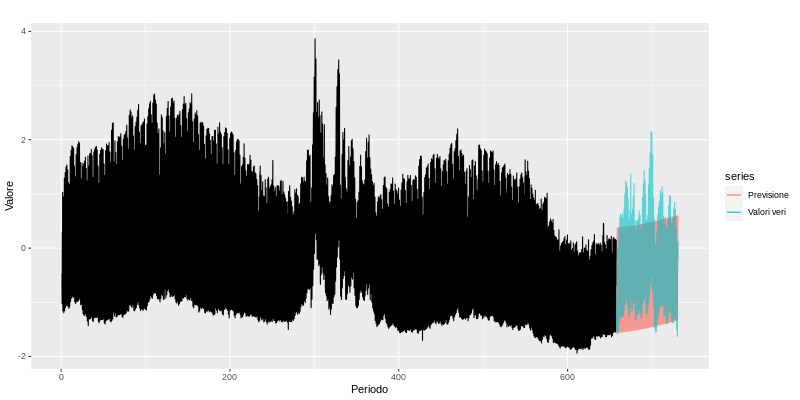

In [ ]:
%%R -w 800 -h 400

autoplot(y_train) +
  autolayer(ucm_pred3,series="Previsione", alpha=0.7) +
  autolayer(y_test, series="Valori veri", alpha=0.6) +
  xlab("Periodo") +
  ylab("Valore")

In [ ]:
#%%R
#ucm_mae_train3 <-mean(abs(unscale(fitted(ucm_fit3$model), tt) - unscale(y_train, tt)))
#ucm_mae_train3

[1] 0.001459703


In [ ]:
%%R
ucm_mae3 <- mean(abs(y_test - ucm_pred3))
ucm_mae3

[1] 0.3988162


# **Machine Learning Models con Python**

In [ ]:
import numpy as np
import pandas as pd
from pandas import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM , SimpleRNN, GRU
from keras.layers import Dense, Dropout
import sklearn.preprocessing
import time
import math
import seaborn as sns

import os

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Vengono eseguiti tutte le manipolazioni di pre processing eseguite con R

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TrainingSet.csv',sep=';')
data.head()

,DATA,Ora,VALORE
0,2018-09-01,1,3646742
1,2018-09-01,2,3273110
2,2018-09-01,3,3069245
3,2018-09-01,4,2969621
4,2018-09-01,5,2944116


In [ ]:
data.isna().count()

DATA      17518
Ora       17518
VALORE    17518
dtype: int64

In [ ]:
a = data.groupby(data['DATA']).count()['Ora']
a.value_counts()

24    728
23      2
Name: Ora, dtype: int64

In [ ]:
#data.loc[data['DATA']=='2019-03-31']
#data.loc[data['DATA']=='2020-03-29']
data.loc[5065.5] = '2019-03-31',  3, 3039997
data = data.sort_index().reset_index(drop=True)
data.loc[13801.5] = '2020-03-29',  3, 2329514
data = data.sort_index().reset_index(drop=True)
data['data'] = pd.to_datetime(data.DATA) + data.Ora.astype('timedelta64[h]')
df = data[['data', 'VALORE']]
df

,data,VALORE
0,2018-09-01 01:00:00,3646742
1,2018-09-01 02:00:00,3273110
2,2018-09-01 03:00:00,3069245
3,2018-09-01 04:00:00,2969621
4,2018-09-01 05:00:00,2944116
...,...,...
17515,2020-08-31 20:00:00,4284919
17516,2020-08-31 21:00:00,4400006
17517,2020-08-31 22:00:00,3965396
17518,2020-08-31 23:00:00,3442262


In [ ]:
def plot_df(df, x, y, title="", xlabel='Periodo', ylabel='Valore', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

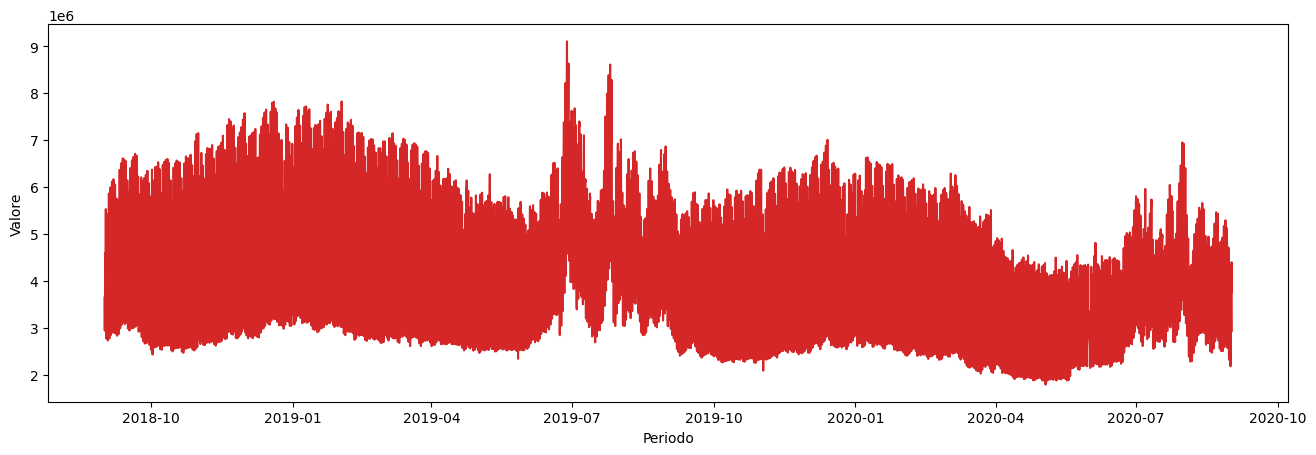

In [ ]:
plot_df(data, x=data.data, y=data.VALORE)    

In [ ]:
df = df.set_index('data')
df_ = df.copy()

Standardizzazione dei valori della serie temporale.

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
df_['VALORE']=scaler.fit_transform(df_['VALORE'].values.reshape(-1,1))

df_.shape

(17520, 1)

Split del dataset (90%/10%) e selezione del sequence_lenght per poter rendere i dati accessibili per i modelli di machine learning.

In [ ]:
def load_data(df, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(df)):
        X_train.append(df.iloc[i-seq_len : i, 0])
        y_train.append(df.iloc[i, 0])
    
    
    X_test = X_train[15768:]             
    y_test = y_train[15768:]
    
    
    X_train = X_train[:15768]           
    y_train = y_train[:15768]
    
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    
    X_train = np.reshape(X_train, (15768, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [ ]:
seq_len = 24*14 

X_train, y_train, X_test, y_test = load_data(df_, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (15768, 336, 1)
y_train.shape =  (15768,)
X_test.shape =  (1416, 336, 1)
y_test.shape =  (1416,)


In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(64,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(64,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(64,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 336, 64)           16896     
_________________________________________________________________
dropout (Dropout)            (None, 336, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 336, 64)           33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 336, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [ ]:
lstm_model.compile(optimizer="adam",loss="MAE")
history= lstm_model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/5
124/124 [==============================] - 30s 58ms/step - loss: 0.1516 - val_loss: 0.0730
Epoch 2/5
124/124 [==============================] - 6s 46ms/step - loss: 0.0840 - val_loss: 0.0495
Epoch 3/5
124/124 [==============================] - 6s 46ms/step - loss: 0.0613 - val_loss: 0.0446
Epoch 4/5
124/124 [==============================] - 6s 46ms/step - loss: 0.0538 - val_loss: 0.0408
Epoch 5/5
124/124 [==============================] - 6s 46ms/step - loss: 0.0492 - val_loss: 0.0427


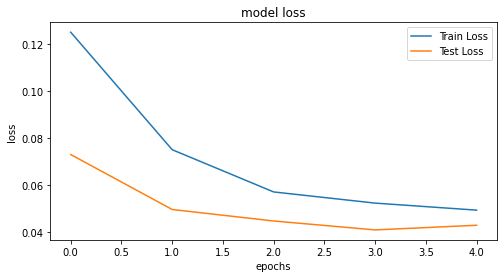

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
lstm_predictions = lstm_model.predict(X_test)

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Valori Attuali')
    plt.plot(predicted, color='red',label='Valori Predetti')
    plt.title(title)
    plt.xlabel('Periodo')
    plt.ylabel('Valore')
    plt.legend()
    plt.show()

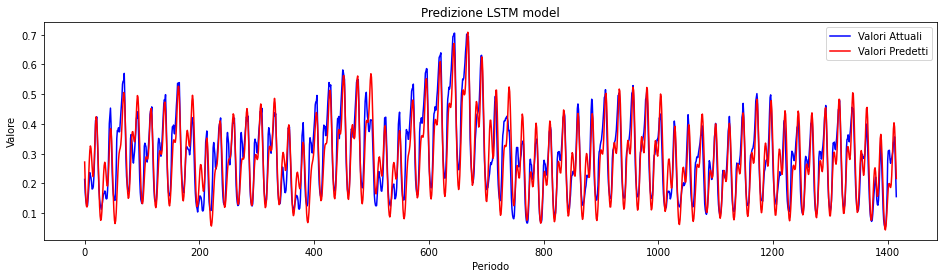

In [ ]:
plot_predictions(y_test, lstm_predictions, "Predizione LSTM model")

In [ ]:
lstm_model.save('lstm.h5')

## RNN

In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(64,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(64,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(64,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 336, 64)           4224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 336, 64)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 336, 64)           8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 336, 64)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
rnn_model.compile(optimizer="adam",loss="MAE")
history2 = rnn_model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/5
124/124 [==============================] - 136s 1s/step - loss: 0.3151 - val_loss: 0.0320
Epoch 2/5
124/124 [==============================] - 130s 1s/step - loss: 0.0924 - val_loss: 0.0220
Epoch 3/5
124/124 [==============================] - 129s 1s/step - loss: 0.0527 - val_loss: 0.0189
Epoch 4/5
124/124 [==============================] - 130s 1s/step - loss: 0.0420 - val_loss: 0.0142
Epoch 5/5
124/124 [==============================] - 128s 1s/step - loss: 0.0349 - val_loss: 0.0184


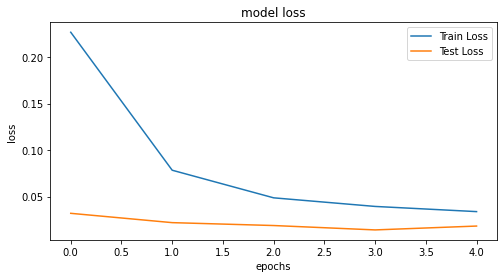

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

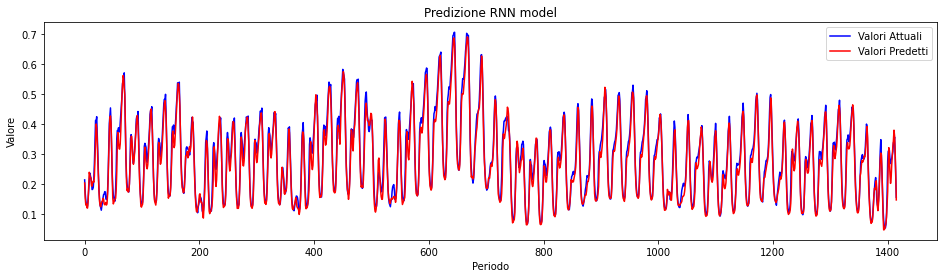

In [ ]:
rnn_predictions = rnn_model.predict(X_test)
plot_predictions(y_test, rnn_predictions, "Predizione RNN model")

In [ ]:
rnn_model.save('simple_rnn_model.h5')

In [ ]:
regressorGRU = Sequential()

regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))

regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))

regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=64, activation='tanh'))

regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer="adam",loss="MAE")

history3= regressorGRU.fit(X_train,y_train,epochs=5,batch_size=128, validation_data=(X_test, y_test))

Epoch 1/5
124/124 [==============================] - 33s 217ms/step - loss: 0.1279 - val_loss: 0.0261
Epoch 2/5
124/124 [==============================] - 25s 199ms/step - loss: 0.0452 - val_loss: 0.0205
Epoch 3/5
124/124 [==============================] - 25s 199ms/step - loss: 0.0367 - val_loss: 0.0227
Epoch 4/5
124/124 [==============================] - 25s 200ms/step - loss: 0.0335 - val_loss: 0.0193
Epoch 5/5
124/124 [==============================] - 25s 199ms/step - loss: 0.0319 - val_loss: 0.0176


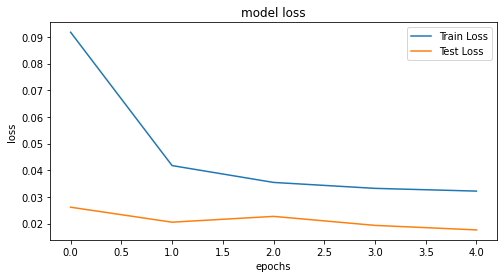

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

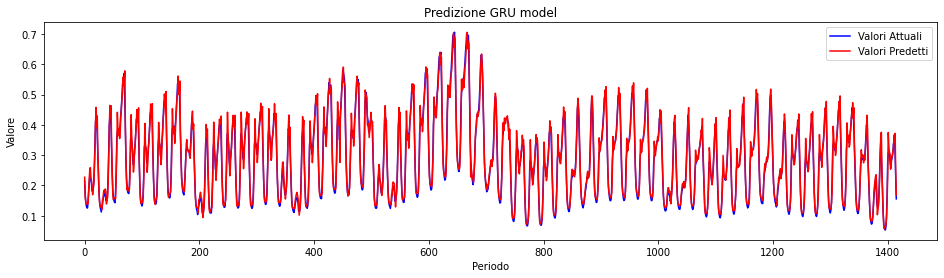

In [ ]:
gru_predictions = regressorGRU.predict(X_test)
plot_predictions(y_test, gru_predictions, "Predizione GRU model")

In [ ]:
regressorGRU.save('gru_model.h5')

# **Predizione Valori utilizzando i migliori modelli** 

In [ ]:
%%R


ARIMA <- Arima(tt,c(3,0,0), list(order=c(0,1,0),
                                 lambda="auto"), 
               include.constant = TRUE )  
pred_ARIMA <- forecast(ARIMA,h = 1464)
pred_best_arima <- DMwR::unscale(as.numeric(pred_ARIMA$mean),
                           tt)

write.csv(pred_best_arima, file = "arima.csv")

In [ ]:
%%R
UCM <- SSModel(tt ~ SSMtrend(1, list(NA,0)) +
                      SSMseasonal(24, NA, "dummy")+
                      SSMcycle(365*24),
                    H = NA)



UCM_fit <- fitSSM(ucm_mod3,
                   log(c(var_train/20, 
                         var_train/100, 
                         var_train/100, 
                         var_train/100, 
                         var_train/10,  
                         var_train/10)), 
)

UCM_fit$optim.out$convergence                                  
UCM_fit$model$Q

UCM_pred <- predict(UCM_fit$model,
                     n.ahead = 1464 ) 
UCM_pred <- DMwR::unscale(as.numeric(UCM_pred), 
                         tt)


write.csv(UCM_pred, file = "ucm.csv")

In [ ]:
def load_test(df, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(df)):
        X_train.append(df.iloc[i-seq_len : i, 0])
        y_train.append(df.iloc[i, 0])
    
    
    X_test = X_train[15720:]             
    y_test = y_train[15720:]
    
    
    X_train = X_train[:15720]           
    y_train = y_train[:15720]
    
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    
    X_train = np.reshape(X_train, (15720, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_test, y_test]

In [ ]:
seq_len = 24*14 

X_test, y_test = load_test(df_, seq_len)

X_test.shape

(1464, 336, 1)

In [ ]:
from keras.models import load_model
best_model = load_model('/content/gru_model.h5')

In [ ]:
test_predict = best_model.predict(X_test)

In [ ]:
gru_test = scaler.inverse_transform(best_model.predict(X_test))

In [ ]:
ml = pd.DataFrame(gru_test, columns=["Value"])
ml = ml['Value']

# **Creazione CSV per consegna** 

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
arima = pd.read_csv('/content/arima.csv')
ucm = pd.read_csv('/content/ucm.csv')

In [ ]:
arima =arima.drop(columns=['Unnamed: 0'])
arima = arima['V1']

In [ ]:
ucm =ucm.drop(columns=['Unnamed: 0'])
ucm =ucm['V1']

In [ ]:
final_csv = pd.DataFrame({'Data':pd.date_range('2020-09-01', periods=1464, freq='H'),
                          'ARIMA':arima,
                          'UCM':ucm,
                          'ML':ml})

In [ ]:
final_csv

,Data,ARIMA,UCM,ML
0,2020-09-01 00:00:00,2522762.332,2826918.922,3882550.500
1,2020-09-01 01:00:00,2281023.134,2503558.642,3276618.250
2,2020-09-01 02:00:00,2176128.792,2337799.157,3124804.250
3,2020-09-01 03:00:00,2134261.266,2276566.473,3090139.500
4,2020-09-01 04:00:00,2137164.838,2278939.835,3076324.750
...,...,...,...,...
1459,2020-10-31 19:00:00,4220643.182,4926698.616,4473293.500
1460,2020-10-31 20:00:00,4336435.476,4852476.752,4304837.000
1461,2020-10-31 21:00:00,3902431.469,4861311.406,4512315.000
1462,2020-10-31 22:00:00,3379818.139,4242667.686,3574300.500


In [ ]:
final_csv['Data'] = pd.to_datetime(final_csv['Data'])
final_csv['Data'], final_csv['Ora'] = final_csv['Data'].dt.normalize(), final_csv['Data'].dt.time

In [ ]:
final_csv['Ora'] = final_csv['Ora'].apply(lambda x: f'{x:%H}').astype(int) + 1

In [ ]:
final_csv = final_csv[['Data','Ora', 'ARIMA', 'UCM', 'ML']]
final_csv

,Data,Ora,ARIMA,UCM,ML
0,2020-09-01,1,2522762.332,2826918.922,3882550.500
1,2020-09-01,2,2281023.134,2503558.642,3276618.250
2,2020-09-01,3,2176128.792,2337799.157,3124804.250
3,2020-09-01,4,2134261.266,2276566.473,3090139.500
4,2020-09-01,5,2137164.838,2278939.835,3076324.750
...,...,...,...,...,...
1459,2020-10-31,20,4220643.182,4926698.616,4473293.500
1460,2020-10-31,21,4336435.476,4852476.752,4304837.000
1461,2020-10-31,22,3902431.469,4861311.406,4512315.000
1462,2020-10-31,23,3379818.139,4242667.686,3574300.500


In [ ]:
final_csv.to_csv('SDMTSA_799647.csv', sep = ";")